
# Low-Speed Adaptive Cruise Control (LS-ACC)
## Option A: Classification-Based Control (Brake / Hold / Accelerate)

**Objective:**  
Build a lightweight ML classifier suitable for embedded systems (STM32) that predicts driving action
based on ultrasonic distance and vehicle speed.

**Classes:**
- `0` → Brake  
- `1` → Hold Speed  
- `2` → Accelerate

This notebook covers:
1. Data generation
2. Labeling logic
3. Model training
4. Evaluation
5. TFLite conversion


In [2]:

# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



## 1. Generate Synthetic Training Data
We simulate ultrasonic distance (cm) and vehicle speed (km/h).


In [8]:

num_per_class = 200

# Brake
dist_brake = np.random.uniform(20, 50, num_per_class)
speed_brake = np.random.uniform(0, 30, num_per_class)

# Hold
dist_hold = np.random.uniform(50, 100, num_per_class)
speed_hold = np.random.uniform(0, 30, num_per_class)

# Accelerate
dist_acc = np.random.uniform(100, 180, num_per_class)
speed_acc = np.random.uniform(0, 30, num_per_class)

X = np.vstack([
    np.column_stack((dist_brake, speed_brake)),
    np.column_stack((dist_hold, speed_hold)),
    np.column_stack((dist_acc, speed_acc))
])

y = np.array(
    [0]*num_per_class +
    [1]*num_per_class +
    [2]*num_per_class
)

print("Label distribution:", np.bincount(y))


print("Input shape:", X.shape)
#print("Label distribution:", np.bincount(y))


Label distribution: [200 200 200]
Input shape: (600, 2)



## 2. Normalize Inputs
Fixed-range normalization (embedded-friendly).


In [10]:

X_norm = X / np.array([200.0, 30.0])



## 3. Build the Classification Model
Small MLP suitable for STM32.


In [11]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
], name="ls_acc_classifier")

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\z665059\OneDrive - ZF Friedrichshafen AG\Documents\my_project_temperature_classification\venv1\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ls_acc_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)


## 4. Train the Model


In [12]:

history = model.fit(
    X_norm, y,
    epochs=80,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2593 - loss: 1.1520 - val_accuracy: 1.0000 - val_loss: 0.6766
Epoch 2/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2667 - loss: 1.1102 - val_accuracy: 1.0000 - val_loss: 0.7811
Epoch 3/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2963 - loss: 1.0832 - val_accuracy: 1.0000 - val_loss: 0.8593
Epoch 4/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3333 - loss: 1.0659 - val_accuracy: 0.8333 - val_loss: 0.9178
Epoch 5/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3741 - loss: 1.0525 - val_accuracy: 0.7167 - val_loss: 0.9503
Epoch 6/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4444 - loss: 1.0408 - val_accuracy: 0.6167 - val_loss: 0.9660
Epoch 7/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5352 - loss: 1.0298 - val_accuracy: 0.5333 - val_loss: 0.9802
Epoch 8/80
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6167 - loss: 1.0182 - val_accuracy: 0.5167 - val


## 5. Plot Training History


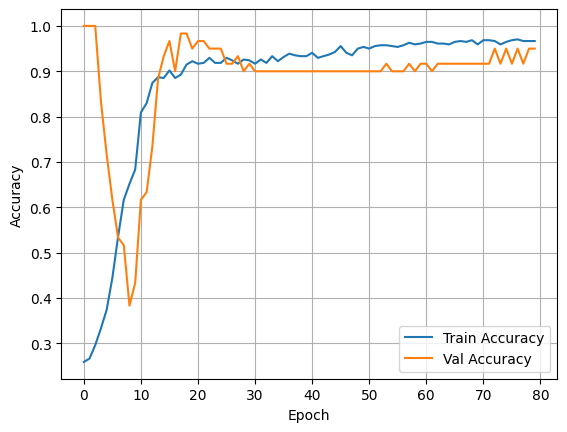

In [13]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



## 6. Test with Sample Scenarios


In [17]:

test_cases = np.array([
    [10, 60],
    [20, 70],
    [40, 15]
])

test_norm = test_cases / np.array([200.0, 30.0])

pred = model.predict(test_norm)
classes = np.argmax(pred, axis=1)

actions = ["Brake", "Hold", "Accelerate"]

for inp, c in zip(test_cases, classes):
    print(f"{inp} → {actions[c]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[10 60] → Brake
[20 70] → Brake
[40 15] → Brake



## 7. Convert to TensorFlow Lite (TFLite)


In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("ls_acc_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as ls_acc_classifier.tflite")
print("Model size (bytes):", len(tflite_model))



## 8. Embedded Deployment Notes
- Normalize inputs using fixed constants.
- ML output is a probability vector of size 3.
- Final control decision must include safety overrides.
